In [4]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import itertools

# from dask import dataframe as dd
from functools import reduce
import matplotlib.pyplot as plt
import pickle
from scipy.stats import wasserstein_distance
import scipy.signal
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams['figure.dpi'] = 100
import sys
import plotly.express as px
from pathlib import Path



In [6]:
# find current working directoy
cwd_path = Path().absolute() 
data_root = cwd_path.parent.parent / "data"
experiment = "cerebellum"
res = "200kb"
chrom_list = [f"chr{x}" for x in range(1, 20)]
chrom_list.append("chrX")

In [13]:
leidens = ["0+1", "2", "4", "6+11", "7"]
cell_types = ["Granule", "Bergmann", "MLI1", "Purkinje", "MLI2+PLI"]

df_dict = {}
# read cerebellem
for ld, ct in zip(leidens, cell_types):
    df_dict[ct] = pd.read_csv(str(data_root / experiment / "IF_ensemble" / f"IF_markers_median_200kb_binned_cerebellum_leiden_{ld}.csv"))


In [14]:
meta = pd.read_csv(str(data_root / "annotation" / "LC1-100k-09022022-mm10-200kb-meta.csv"))

In [16]:
pol_mdf_dict = {}
spk_mdf_dict = {}
for ct in cell_types[1:]:
    pol_df = pd.read_csv(str(data_root /experiment/ "peak_detection" /f"091423_version2_{ct}_RNAPIISer5-P.csv")).merge(meta, how = "left")
    spk_df = pd.read_csv(str(data_root /experiment/ "peak_detection" /f"091423_version2_{ct}_SF3A66.csv")).merge(meta, how = "left")
    pol_mdf_dict[ct] = pol_df
    spk_mdf_dict[ct] = spk_df

([<matplotlib.axis.XTick at 0x14ed2de80>,
 [Text(0, 0, '0-10'),
  Text(1, 0, '10-20'),
  Text(2, 0, '20-30'),
  Text(3, 0, '30-40'),
  Text(4, 0, '40-50'),
  Text(5, 0, '50-60'),
  Text(6, 0, '60-70'),
  Text(7, 0, '70-80'),
  Text(8, 0, '80-90'),
  Text(9, 0, '90-100'),
  Text(10, 0, '100-110'),
  Text(11, 0, '150-160'),
  Text(12, 0, '170-180')])

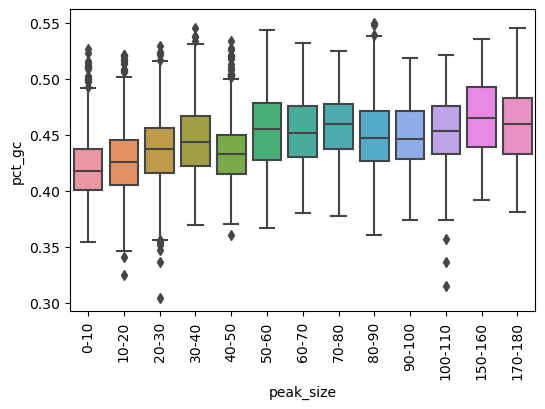

In [17]:
# plot peak_size vs markers or meta markers you want to check
# segment bins into 10 bins per boxplot
check_ct = "Purkinje"
check_marker = "pct_gc"
bin_segment = 10

tdf = pol_mdf_dict[check_ct]

sns.boxplot(y = tdf[check_marker], x = tdf["peak_size"]  // bin_segment)
labels = [int(label.get_text()) for label in plt.gca().get_xticklabels()]
plt.xticks(range(len(labels)), [f"{l*bin_segment}-{(l+1) *bin_segment}" for l in labels], rotation=90 )
# plt.show()

([<matplotlib.axis.XTick at 0x14ef24d90>,
 [Text(0, 0, '0-10'),
  Text(1, 0, '10-20'),
  Text(2, 0, '20-30'),
  Text(3, 0, '30-40'),
  Text(4, 0, '40-50'),
  Text(5, 0, '50-60'),
  Text(6, 0, '60-70'),
  Text(7, 0, '70-80'),
  Text(8, 0, '80-90'),
  Text(9, 0, '90-100'),
  Text(10, 0, '100-110'),
  Text(11, 0, '150-160'),
  Text(12, 0, '170-180')])

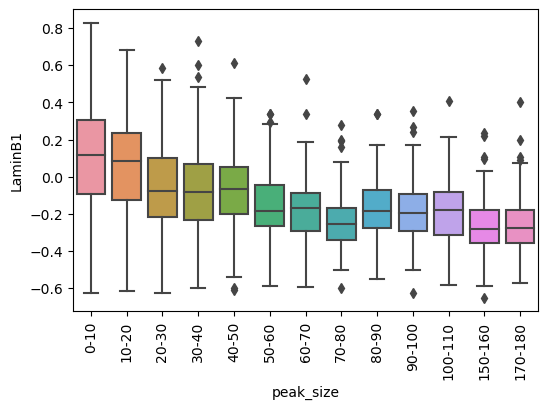

In [18]:
check_ct = "Purkinje"
check_marker = "LaminB1"
bin_segment = 10

tdf = pol_mdf_dict[check_ct]

sns.boxplot(y = tdf[check_marker], x = tdf["peak_size"]  // bin_segment)
labels = [int(label.get_text()) for label in plt.gca().get_xticklabels()]
plt.xticks(range(len(labels)), [f"{l*bin_segment}-{(l+1) *bin_segment}" for l in labels], rotation=90 )
# plt.show()

# Plot three category different associated feature if you want to change the thresholding values

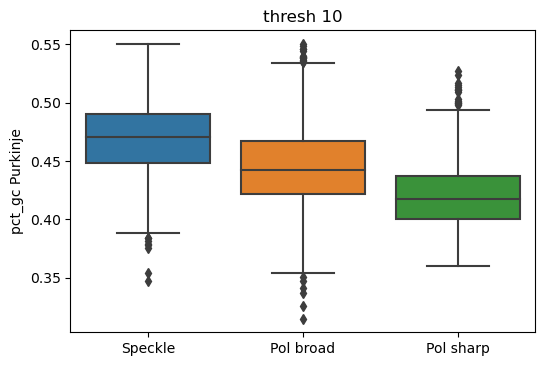

In [19]:
# set the bin threshold
bin_thresh = 10 # when is 10, it is the same as our current partition
ct= "Purkinje"
check_m = "pct_gc"

tdf = spk_mdf_dict[ct]
tdf = tdf[~tdf["200kb name"].str.contains("X")]
# grab speckle bins
spk_bins = tdf["200kb name"].values
# grab polII bins
tdf = pol_mdf_dict[ct]
tdf = tdf[~tdf["200kb name"].str.contains("X")]
pol_bins_short = tdf[tdf["peak_size"] <= bin_thresh]["200kb name"].values
pol_bins_long = tdf[tdf["peak_size"]> bin_thresh]["200kb name"].values

# form x and y accordingly
# x
d1 = tdf[tdf["200kb name"].isin(spk_bins)][check_m].values
d2 = tdf[tdf["200kb name"].isin(pol_bins_long)][check_m].values
d3 = tdf[tdf["200kb name"].isin(pol_bins_short)][check_m].values

# y
lb1 = ["Speckle"] * len(d1)
lb2 = ["Pol broad"] * len(d2)
lb3 = ["Pol sharp"] * len(d3)

# boxplot
sns.boxplot(x = lb1 + lb2 + lb3, y = np.hstack((d1, d2, d3)), showfliers = True)
plt.ylabel(f"{check_m} {ct}")
plt.title(f"thresh {bin_thresh}")
plt.show()

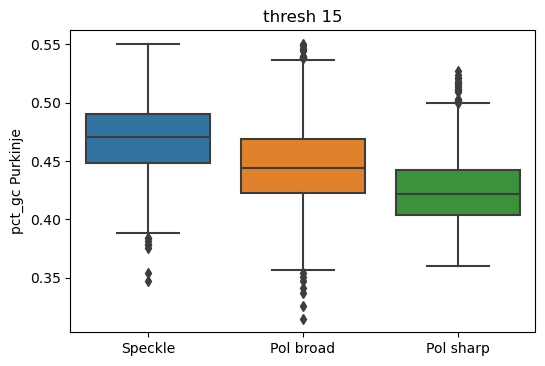

In [20]:
# Plot three category different associated feature if you want to change the thresholding values
# set the bin threshold
bin_thresh = 15 # when is 10, it is the same as our current partition
ct= "Purkinje"
check_m = "pct_gc"

tdf = spk_mdf_dict[ct]
tdf = tdf[~tdf["200kb name"].str.contains("X")]
# grab speckle bins
spk_bins = tdf["200kb name"].values
# grab polII bins
tdf = pol_mdf_dict[ct]
tdf = tdf[~tdf["200kb name"].str.contains("X")]
pol_bins_short = tdf[tdf["peak_size"] <= bin_thresh]["200kb name"].values
pol_bins_long = tdf[tdf["peak_size"]> bin_thresh]["200kb name"].values

# form x and y accordingly
# x
d1 = tdf[tdf["200kb name"].isin(spk_bins)][check_m].values
d2 = tdf[tdf["200kb name"].isin(pol_bins_long)][check_m].values
d3 = tdf[tdf["200kb name"].isin(pol_bins_short)][check_m].values

# y
lb1 = ["Speckle"] * len(d1)
lb2 = ["Pol broad"] * len(d2)
lb3 = ["Pol sharp"] * len(d3)

# boxplot
sns.boxplot(x = lb1 + lb2 + lb3, y = np.hstack((d1, d2, d3)), showfliers = True)
plt.ylabel(f"{check_m} {ct}")
plt.title(f"thresh {bin_thresh}")
plt.show()